# Becomexpert AI Course: HW2 -- Sajad Chelabi
## Title: Adult income Classification
### Binary classification with various features and two labels(over 50k income and less than 50k). So, the target is find any test sample or future samples class with their features.

In [77]:
%matplotlib notebook
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve, auc, classification_report

from ipywidgets import interact, IntSlider, FloatLogSlider, ToggleButtons

### Import Dataset

In [2]:
df = pd.read_csv('adult_income.csv')
df.drop_duplicates(inplace = True)
df.reset_index(drop=True, inplace=True)
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


### Checking data types and missing values

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48790 entries, 0 to 48789
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48790 non-null  int64 
 1   workclass        48790 non-null  object
 2   fnlwgt           48790 non-null  int64 
 3   education        48790 non-null  object
 4   educational-num  48790 non-null  int64 
 5   marital-status   48790 non-null  object
 6   occupation       48790 non-null  object
 7   relationship     48790 non-null  object
 8   race             48790 non-null  object
 9   gender           48790 non-null  object
 10  capital-gain     48790 non-null  int64 
 11  capital-loss     48790 non-null  int64 
 12  hours-per-week   48790 non-null  int64 
 13  native-country   48790 non-null  object
 14  income           48790 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


### Checking the statistical features of the data

In [4]:
df.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48790.000000,4.879000e+04,48790.000000,48790.000000,48790.000000,48790.000000
mean,38.652798,1.896690e+05,10.078807,1080.217688,87.595573,40.425886
std,13.708493,1.056172e+05,2.570046,7455.905921,403.209129,12.392729
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175550e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781385e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376062e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [5]:
df['workclass'].value_counts().to_frame()

,count
workclass,
Private,33860
Self-emp-not-inc,3861
Local-gov,3136
?,2795
State-gov,1981
Self-emp-inc,1694
Federal-gov,1432
Without-pay,21
Never-worked,10


#### Do the above action for each feature to check their values and detect not relative ones like '?'

## Data Cleaning
#### Correct '?' in features and replace them to 'other' value of that feature.

In [6]:
df['workclass'].replace('?', 'other', inplace=True)
df['occupation'].replace('?', 'other', inplace=True)
df['native-country'].replace('?', 'other', inplace=True)

#### Using value_counts to detect any not relative values and errors in features.

In [7]:
df[['education', 'educational-num']].value_counts().to_frame()

,,count
education,educational-num,
HS-grad,9,15770
Some-college,10,10863
Bachelors,13,8013
Masters,14,2656
Assoc-voc,11,2060
11th,7,1812
Assoc-acdm,12,1601
10th,6,1389
7th-8th,4,954


#### The above line of code shows that 'education' assigned to 'educational-num' perfectly. So, we can remove 'education' feature and using its numerical type. And also 'fnlwgt' that is not well defined!

In [8]:
df.drop(['fnlwgt', 'education'], axis = 1, inplace = True)

### Binary Encoding
#### Change gender and income values to binary, and also choose 'US' as the most value of 'native country' and 'Private' as the most in 'workclass' to simple their categories. So, in further handling actions where apply one-hot encoding the features will come to have acceptable columns.

In [9]:
df.gender = df.gender.apply(lambda x: 1 if x == 'Male' else 0)
df.income = df.income.apply(lambda x: 1 if x == '>50K' else 0)
df['native-country'] = df['native-country'].apply(lambda x: 1 if x == 'United-States' else 0)
df.workclass = df.workclass.apply(lambda x: 1 if x == 'Private' else 0)
df.head()

,age,workclass,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,1,7,Never-married,Machine-op-inspct,Own-child,Black,1,0,0,40,1,0
1,38,1,9,Married-civ-spouse,Farming-fishing,Husband,White,1,0,0,50,1,0
2,28,0,12,Married-civ-spouse,Protective-serv,Husband,White,1,0,0,40,1,1
3,44,1,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,1,7688,0,40,1,1
4,18,0,10,Never-married,other,Own-child,White,0,0,0,30,1,0


### Rename some values for simplicity
#### Separate more repeated  values from others and make optimized categories, again for simplicity and better handling.

In [10]:
df['marital-status'].replace({'Married-civ-spouse': 'Married', 'Separated': 'Other', 'Widowed': 'Other',
                             'Married-spouse-absent': 'Other', 'Married-AF-spouse': 'Other'}, inplace=True)
df.race.replace({'Asian-Pac-Islander': 'Other', 'Amer-Indian-Eskimo': 'Other'}, inplace=True)

In [11]:
df['race'].value_counts().to_frame()

,count
race,
White,41714
Black,4683
Other,2393


### One Hot Encoding
#### Do it for make data frame complete numerical in order to apply whole classification methods on it.

In [12]:
df = df.join(pd.get_dummies(df['marital-status'], prefix = 'marital-status').astype(int)).drop('marital-status', axis=1)
df = df.join(pd.get_dummies(df['occupation'], prefix = 'occupation').astype(int)).drop('occupation', axis=1)
df = df.join(pd.get_dummies(df['relationship'], prefix = 'relation').astype(int)).drop('relationship', axis=1)
df = df.join(pd.get_dummies(df['race'], prefix = 'race').astype(int)).drop('race', axis=1)

In [13]:
df.head(3)

,age,workclass,educational-num,gender,capital-gain,capital-loss,hours-per-week,native-country,income,marital-status_Divorced,...,occupation_other,relation_Husband,relation_Not-in-family,relation_Other-relative,relation_Own-child,relation_Unmarried,relation_Wife,race_Black,race_Other,race_White
0,25,1,7,1,0,0,40,1,0,0,...,0,0,0,0,1,0,0,1,0,0
1,38,1,9,1,0,0,50,1,0,0,...,0,1,0,0,0,0,0,0,0,1
2,28,0,12,1,0,0,40,1,1,0,...,0,1,0,0,0,0,0,0,0,1


## Split Data
#### Take 30 percent of data in order to test section and the other for train the model. Features are all columns except income and Label is income for this classifiaction problem.

In [14]:
X = df.drop('income', axis=1)
y = df.income

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Normalization
#### Using Std scaler to make all features in same range and also prevent any bad scaling in unbalanced range such as capital-gain which have one 99k out of range value.

In [15]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

## Model Selection
### For this scenario using these models for classificaiton: Logistic regression, K-Nearest Neigbors Classifier, Support Vector Machines, Decision Trees, Random Forest Classifier, and AdaBoost Classifier.

### Logistic Regression

In [16]:
logistic = LogisticRegression(max_iter=10000).fit(X_train_s, y_train)
y_pred_logistic = logistic.predict(X_test_s)
y_score_logistic = logistic.decision_function(X_test_s)
logistic.score(X_test_s, y_test)

0.8507207761153242

#### Model Performance: Pretty simple and fast model with around 0.85 accuracy.

### K-Nearest-Neighbors Classifier
#### Search n_neighbors in range [1,2, 3, 4, 5, 10, 20, 30, 50] and pick 10 as the best one.

In [17]:
knn = KNeighborsClassifier(n_neighbors=10).fit(X_train_s, y_train)
y_pred_knn = knn.predict(X_test_s)
knn.score(X_test_s, y_test)

0.8354854136776662

#### Model Performance: High computation and has difficulty in order to adjust 'k' hyper parameter with accuracy lower than previous models.

### Support Vector Machines
#### Using just default hyperparameters such as kernel, because of its time consuming.

In [18]:
svc = SVC().fit(X_train_s, y_train)
y_pred_svc = svc.predict(X_test_s)
y_score_svc = svc.decision_function(X_test_s)
svc.score(X_test_s, y_test)

0.8500375760060122

#### Model Performance: Very High computation and take lots of time for find and ajust its hyperparameters such as kernel, C, and gamma for RBF kernel. And also the model score is same as simple logistic.

### Decision Trees
#### Check max depth of 1 to 30 and pick the best one.

In [19]:
dt = DecisionTreeClassifier(max_depth=9).fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
dt.score(X_test, y_test)

0.8600806176128988

#### It's Awsome! dt model is trained very fast and also its accuracy is more than other models until now. This model have also priority of using original data without any normalization.

### Random Forest Classifier
#### Such as previous one search in various range of number of estimators and max depth hyperparameters in order to find best ones.

In [20]:
rf = RandomForestClassifier(n_estimators=50, max_depth=20).fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf.score(X_test, y_test)

0.8622668579626973

#### Model Performance: RF performance is really near to single decision tree, but obviously it is more robust in overfitting.

### AdaBoost

In [21]:
dt1 = DecisionTreeClassifier(max_depth=5)
ada = AdaBoostClassifier(estimator=dt1, n_estimators=20, learning_rate=1).fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)
y_score_ada = ada.decision_function(X_test)
ada.score(X_test, y_test)

0.8630183780829405

#### Model Performance: Same as dt and rf.

## Model Evaluation

### Check Accuracy, Precision, Recall, F1-score metrics for each model
#### Using toggle widget to select any evaluation metrics and then see the result. put y-limit from 0.5 to 0.9 in order to have better visualization and more comfortable to make comparison among models.

In [72]:
# Create Metrics lists
Accuracy_scores = [accuracy_score(y_test, y_pred_logistic), accuracy_score(y_test, y_pred_knn),
                   accuracy_score(y_test, y_pred_svc), accuracy_score(y_test, y_pred_dt),
                   accuracy_score(y_test, y_pred_rf), accuracy_score(y_test, y_pred_ada)]

Precision_scores = [precision_score(y_test, y_pred_logistic), precision_score(y_test, y_pred_knn),
                    precision_score(y_test, y_pred_svc), precision_score(y_test, y_pred_dt),
                    precision_score(y_test, y_pred_rf), precision_score(y_test, y_pred_ada)]

Recall_scores = [recall_score(y_test, y_pred_logistic), recall_score(y_test, y_pred_knn),
                 recall_score(y_test, y_pred_svc), recall_score(y_test, y_pred_dt),
                 recall_score(y_test, y_pred_rf), recall_score(y_test, y_pred_ada)]

F1_scores = [f1_score(y_test, y_pred_logistic), f1_score(y_test, y_pred_knn),
             f1_score(y_test, y_pred_svc), f1_score(y_test, y_pred_dt),
             f1_score(y_test, y_pred_rf), f1_score(y_test, y_pred_ada)]

models = ['Logistic', 'KNN', 'SVM', 'DT', 'RF', 'AdaBoost']
params = [Accuracy_scores, Precision_scores, Recall_scores, F1_scores]

def plot_score(param):
    if param == 'Accuracy':
        p = params[0]
    elif param == 'Precision':
        p = params[1]
    elif param == 'Recall':
        p = params[2]
    else:
        p = params[3]

    plt.clf()
    fig, ax = plt.subplots()
    ax.set_ylim(0.5, 0.9)
    ax.bar(models, p, color='red', width=0.2)
    ax.set_title('Scores Evaluation')
    ax.set_ylabel(param)
    ax.grid()
    
    plt.show()

box = ToggleButtons(
    options=['Accuracy', 'Precision', 'Recall', 'F1'],
    description='Select:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Accuracy_scores', 'Precision_scores', 'Recall_scores', 'F1_scores']
)

interact(plot_score, param=box)

interactive(children=(ToggleButtons(description='Select:', options=('Accuracy', 'Precision', 'Recall', 'F1'), …

<function __main__.plot_score(param)>

### Precision-recall curve
#### This is another favorite metrics that usually used for model evaluations. The best choice is marked with small red circle.

<IPython.core.display.Javascript object>


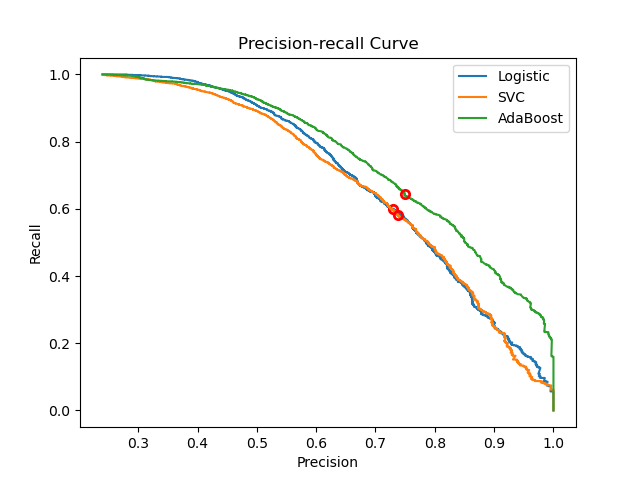

In [23]:
precision_logistic, recall_logistic, thresholds_logistic = precision_recall_curve(y_test, y_score_logistic)
precision_svc, recall_svc, thresholds_svc = precision_recall_curve(y_test, y_score_svc)
precision_ada, recall_ada, thresholds_ada = precision_recall_curve(y_test, y_score_ada)

z_logistic = np.argmin(np.abs(thresholds_logistic))
z_svc = np.argmin(np.abs(thresholds_svc))
z_ada = np.argmin(np.abs(thresholds_ada))

plt.figure()

plt.plot(precision_logistic, recall_logistic, label='Logistic')
plt.plot(precision_logistic[z_logistic], recall_logistic[z_logistic], 'o', markersize = 6, fillstyle = 'none', c='r', mew=2)

plt.plot(precision_svc, recall_svc, label='SVC')
plt.plot(precision_svc[z_svc], recall_svc[z_svc], 'o', markersize = 6, fillstyle = 'none', c='r', mew=2)

plt.plot(precision_ada, recall_ada, label='AdaBoost')
plt.plot(precision_ada[z_ada], recall_ada[z_ada], 'o', markersize = 6, fillstyle = 'none', c='r', mew=2)

plt.title('Precision-recall Curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.legend()
plt.show()

### ROC Curve & Area Under Curve (AUC) parameter
#### Again using another useful metric and create it for top models.

<IPython.core.display.Javascript object>


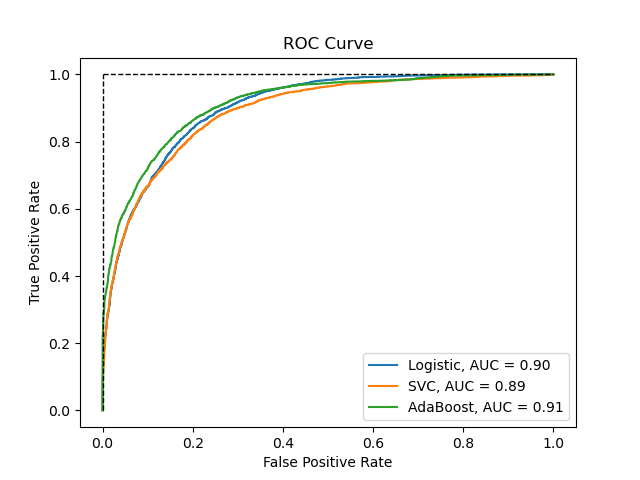

In [24]:
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_score_logistic)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)

fpr_svc, tpr_svc, _ = roc_curve(y_test, y_score_svc)
roc_auc_svc = auc(fpr_svc, tpr_svc)

fpr_ada, tpr_ada, _ = roc_curve(y_test, y_score_ada)
roc_auc_ada = auc(fpr_ada, tpr_ada)

plt.figure()

plt.plot(fpr_logistic, tpr_logistic, label = 'Logistic, AUC = {:.2f}'.format(roc_auc_logistic))
plt.plot(fpr_svc, tpr_svc, label = 'SVC, AUC = {:.2f}'.format(roc_auc_svc))
plt.plot(fpr_ada, tpr_ada, label = 'AdaBoost, AUC = {:.2f}'.format(roc_auc_ada))

plt.plot([0, 1], [1, 1], color='k', lw=1, linestyle='--')
plt.plot([0, 0], [0, 1], color='k', lw=1, linestyle='--')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### Comparison tree based classifiers feature importances
#### Just for recognize difference between tree based models (DecisionTree, Randomforest, AdaBoost(base=DT)) feature importances list. 

In [25]:
# Decision Tree Classifier Feature importances
importances_dt = dict(zip(dt.feature_names_in_, dt.feature_importances_))
top5_dt = sorted(importances_dt.items(), key=lambda x: x[1], reverse=True)[:5]

# Random Forest Classifier Feature importances
importances_rf = dict(zip(rf.feature_names_in_, rf.feature_importances_))
top5_rf = sorted(importances_rf.items(), key=lambda x: x[1], reverse=True)[:5]

# AdaBoost Classifier Feature importances
importances_ada = dict(zip(ada.feature_names_in_, ada.feature_importances_))
top5_ada = sorted(importances_ada.items(), key=lambda x: x[1], reverse=True)[:5]

#### Make top5 visualization

<IPython.core.display.Javascript object>


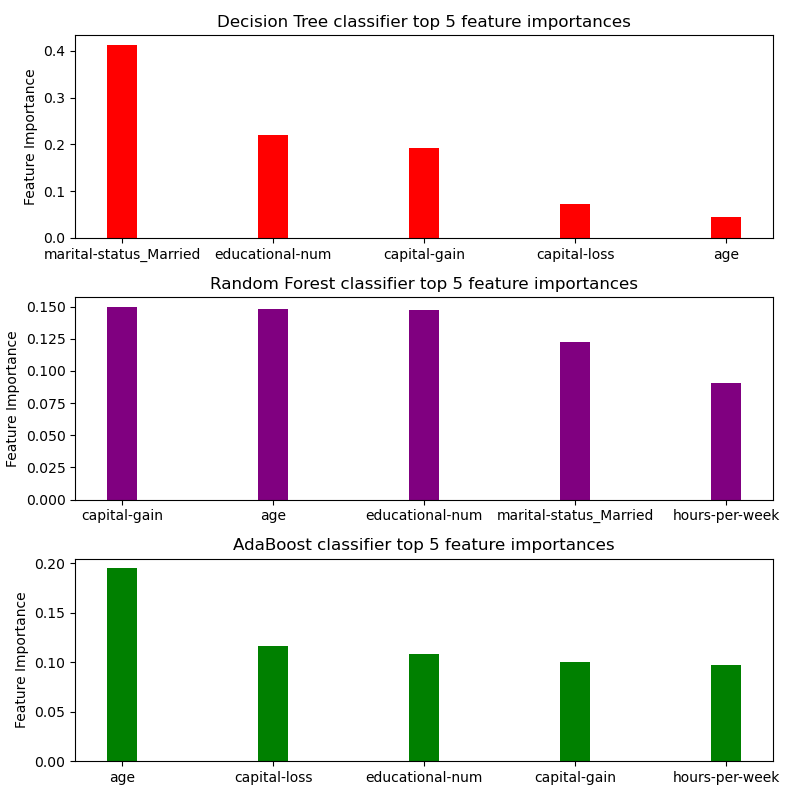

In [69]:
top5_dt_list = [top5_dt[0][0], top5_dt[1][0], top5_dt[2][0], top5_dt[3][0], top5_dt[4][0]]
top5_dt_val = [top5_dt[0][1], top5_dt[1][1], top5_dt[2][1], top5_dt[3][1], top5_dt[4][1]]

top5_rf_list = [top5_rf[0][0], top5_rf[1][0], top5_rf[2][0], top5_rf[3][0], top5_rf[4][0]]
top5_rf_val = [top5_rf[0][1], top5_rf[1][1], top5_rf[2][1], top5_rf[3][1], top5_rf[4][1]]

top5_ada_list = [top5_ada[0][0], top5_ada[1][0], top5_ada[2][0], top5_ada[3][0], top5_ada[4][0]]
top5_ada_val = [top5_ada[0][1], top5_ada[1][1], top5_ada[2][1], top5_ada[3][1], top5_ada[4][1]]

fig, axes = plt.subplots(3, 1, figsize=(8, 8))

axes[0].bar(top5_dt_list, top5_dt_val, color='red', width = 0.2)
axes[0].set_title('Decision Tree classifier top 5 feature importances')
axes[0].set_ylabel('Feature Importance')

axes[1].bar(top5_rf_list, top5_rf_val, color='purple', width = 0.2)
axes[1].set_title('Random Forest classifier top 5 feature importances')
axes[1].set_ylabel('Feature Importance')

axes[2].bar(top5_ada_list, top5_ada_val, color='green', width = 0.2)
axes[2].set_title('AdaBoost classifier top 5 feature importances')
axes[2].set_ylabel('Feature Importance')

plt.tight_layout()
plt.show()

## Select AdaBoost Classifier as the best model. Now, make search in model to find its best hyperparameters.
#### First, do it with handy method and create online observation of hyperparameter's influence on the model.

In [27]:
def Search(max_depth, n_estimators, alpha):
    estimator = DecisionTreeClassifier(max_depth=max_depth)
    model = AdaBoostClassifier(estimator=estimator, n_estimators=n_estimators, learning_rate=alpha).fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_score = model.decision_function(X_test)
    accuracy = model.score(X_test, y_test)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    result = 'Model Accuracy = {:.3f}, roc_auc = {:.3f}'.format(accuracy, roc_auc)
    return result

interact(Search, max_depth = IntSlider(min=1, max=20, step=1, value=5),
         n_estimators = IntSlider(min=1, max=100, step=10, value=50),
         alpha = FloatLogSlider(value=1, base=10, min=-3, max=2, step=1))

interactive(children=(IntSlider(value=5, description='max_depth', max=20, min=1), IntSlider(value=50, descript…

<function __main__.Search(max_depth, n_estimators, alpha)>

#### Optimal values for hyperparameters from above searching obtained as: max_depth = 3, n_estimators = 40, alpha = 1 with Accuracy = 0.869 and roc_auc = 0.922

### GridSearchCV

In [28]:
base1 = DecisionTreeClassifier(max_depth=1)
base2 = DecisionTreeClassifier(max_depth=3)
base3 = DecisionTreeClassifier(max_depth=10)

param_grid = {
    'n_estimators': [30, 40, 50],
    'learning_rate': [0.1, 1, 10],
    'base_estimator': [base1, base2, base3]
}

grid_search = GridSearchCV(estimator=AdaBoostClassifier(), param_grid=param_grid, n_jobs=-1, scoring='accuracy')

grid_model = grid_search.fit(X_train, y_train)
best_score = grid_model.best_score_
best_param = grid_model.best_params_
print('model best score = {:.4f}\nmodel best_params = {}'.format(best_score, best_param))

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


model best score = 0.8695
model best_params = {'base_estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 1, 'n_estimators': 40}


#### The results same as previous handy method and again optimal values of hyperparameters are: max_depth = 3, n_estimators = 40, alpha = 1

## Using cross-val-score for evaluate model

<IPython.core.display.Javascript object>


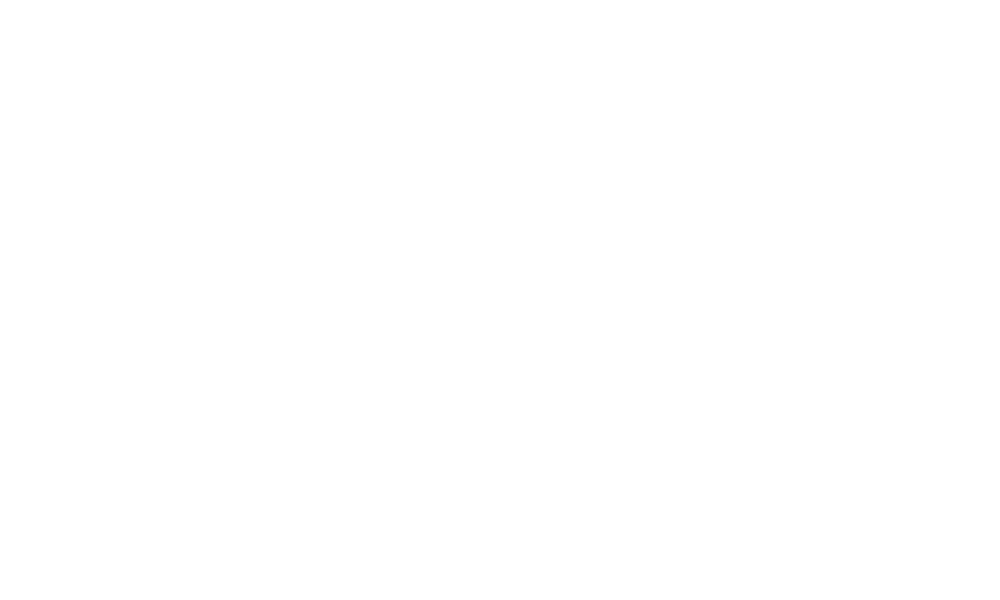

Optimal n_estimators: 31
Test Accuracy with Optimal n: 0.87


In [71]:
n_estimator = range(1,60,5)
cv_scores = []

for n in n_estimator:
    estimator = DecisionTreeClassifier(max_depth=3)
    model_cv = AdaBoostClassifier(estimator=estimator, n_estimators=n, learning_rate=1)
    scores = cross_val_score(model_cv, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# Plot the cross-validation scores
plt.figure(figsize=(10, 6))
plt.plot(n_estimator, cv_scores, marker='o')
plt.xlabel('Number of estimators')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Cross-Validation Accuracy vs. n_estimators')
plt.xticks(n_estimator)
plt.grid()
plt.show()

# Find the optimal K
optimal_n = n_estimator[cv_scores.index(max(cv_scores))]
print(f"Optimal n_estimators: {optimal_n}")

# Train the model with the optimal K
model_optimal = AdaBoostClassifier(estimator=estimator, n_estimators=optimal_n, learning_rate=1).fit(X_train, y_train)

# Evaluate the model
accuracy_opt = model_optimal.score(X_test, y_test)
print(f"Test Accuracy with Optimal n: {accuracy_opt:.2f}")

#### The best model obtained from various search and simulations with accuracy of 0.87.

### Optimal model: AdaBoost Classifier = learning rate = 1, base estimator = DecisionTree(max_depth=3), number of estimators = 31. Data split: 70% Train set and 30% Test set

## Results

### Visualize any metrics for the optimal model.

<IPython.core.display.Javascript object>


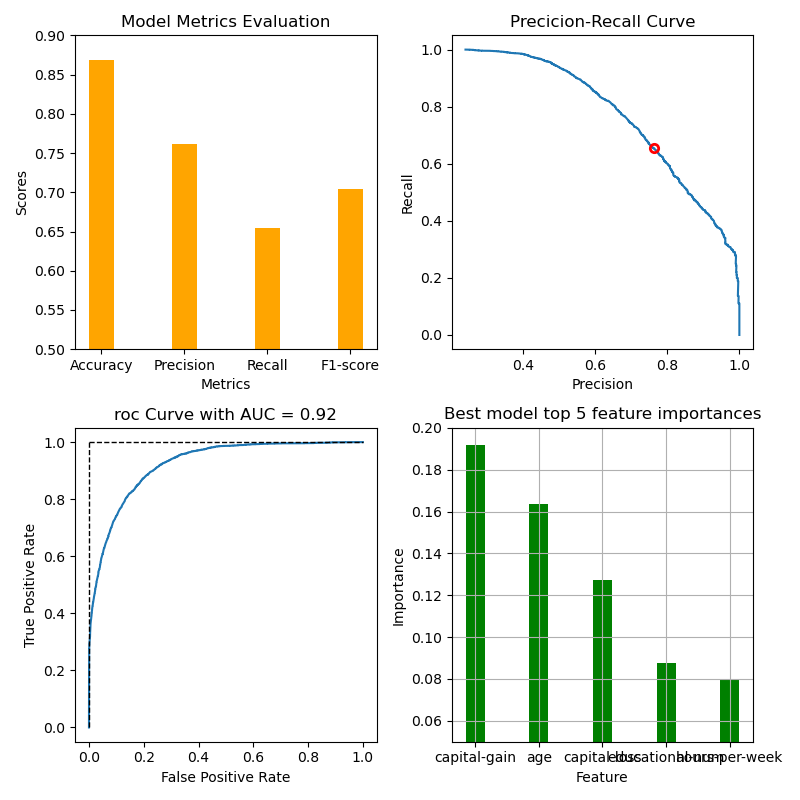

              precision    recall  f1-score   support

           0       0.90      0.94      0.92     11126
           1       0.76      0.65      0.70      3511

    accuracy                           0.87     14637
   macro avg       0.83      0.80      0.81     14637
weighted avg       0.86      0.87      0.86     14637



In [79]:
# Create the best model
estimator = DecisionTreeClassifier(max_depth=3)
Best_Model = AdaBoostClassifier(estimator=estimator, n_estimators=31, learning_rate=1).fit(X_train, y_train)
y_pred_best = Best_Model.predict(X_test)
y_score_best = Best_Model.decision_function(X_test)

# Calculate Accuracy, Precision, Recall, and F1-score Metrics
Accuracy_best = accuracy_score(y_test, y_pred_best)
Precision_best = precision_score(y_test, y_pred_best)
Recall_best = recall_score(y_test, y_pred_best)
F1_best = f1_score(y_test, y_pred_best)

Metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
Metrics_val = [Accuracy_best, Precision_best, Recall_best, F1_best]

# Calculate Precision-Recall Curve
precision_best, recall_best, thresholds_best = precision_recall_curve(y_test, y_score_best)
z_best = np.argmin(np.abs(thresholds_best))

# Calculate roc-auc
fpr_best, tpr_best, _ = roc_curve(y_test, y_score_best)
roc_auc_best = auc(fpr_best, tpr_best)

# Calculate Feature Importances
importances_best = dict(zip(Best_Model.feature_names_in_, Best_Model.feature_importances_))
top5_best = sorted(importances_best.items(), key=lambda x: x[1], reverse=True)[:5]
# Create top5 list
top5_best_list = [top5_best[0][0], top5_best[1][0], top5_best[2][0], top5_best[3][0], top5_best[4][0]]
top5_best_val = [top5_best[0][1], top5_best[1][1], top5_best[2][1], top5_best[3][1], top5_best[4][1]]

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# Visualize Accuracy, Precision, Recall, and F1-score Metrics
axes[0,0].set_ylim(0.5,0.9)
axes[0,0].bar(Metrics, Metrics_val, color='orange', width=0.3)
axes[0,0].set_title('Model Metrics Evaluation')
axes[0,0].set_xlabel('Metrics')
axes[0,0].set_ylabel('Scores')

# Visualize Precision-Recall Curve
axes[0,1].plot(precision_best, recall_best)
axes[0,1].plot(precision_best[z_best], recall_best[z_best], 'o', markersize = 6, fillstyle = 'none', c='r', mew=2)
axes[0,1].set_title('Precicion-Recall Curve')
axes[0,1].set_xlabel('Precision')
axes[0,1].set_ylabel('Recall')

# Visualize roc-auc
axes[1,0].plot(fpr_best, tpr_best, label = 'AUC = {:.2f}'.format(roc_auc_best))
axes[1,0].plot([0, 1], [1, 1], color='k', lw=1, linestyle='--')
axes[1,0].plot([0, 0], [0, 1], color='k', lw=1, linestyle='--')
axes[1,0].set_title('roc Curve with AUC = {:.2f}'.format(roc_auc_best))
axes[1,0].set_xlabel('False Positive Rate')
axes[1,0].set_ylabel('True Positive Rate')

# Visualize Top 5 Feature Importances
axes[1,1].set_ylim(0.05,0.2)
axes[1,1].bar(top5_best_list, top5_best_val, color='green', width = 0.3)
axes[1,1].set_title('Best model top 5 feature importances')
axes[1,1].set_xlabel('Feature')
axes[1,1].set_ylabel('Importance')


plt.grid()
plt.tight_layout()
plt.show()

# Show classification report of the model
report = classification_report(y_test, y_pred_best)
print(report)